In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline
import seaborn as sns
import math
import ast
import progressbar
import os
import networkx as nx

# import umap
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import LinearSegmentedColormap
import statsmodels.formula.api as smf

## Import the data
 First we load all the datasets that we will be using.

In [2]:
# Data paths (folder and path are seperated in order to easily check if the pickle version of the file exists)
characters_metadata_path    = {'path':'./data/MovieSummaries/character.metadata',   'extension':'.tsv'}
movies_metadata_path        = {'path':'./data/MovieSummaries/movie.metadata',       'extension':'.tsv'}
movie_summaries_path        = {'path':'./data/MovieSummaries/plot_summaries',       'extension':'.txt'}

imdb_names_path         = {'path':'./data/imdb/imdb_names',         'extension':'.tsv'} 
imdb_principals_path    = {'path':'./data/imdb/imdb_principals',    'extension':'.tsv'}
imdb_ratings_path       = {'path':'./data/imdb/imdb_ratings',       'extension':'.tsv'} 
imdb_titles_path        = {'path':'./data/imdb/imdb_titles',        'extension':'.tsv'}

kaggle_awards_path = {'path':'./data/kaggle/the_oscar_award', 'extension':'.csv'}

# Column names for the MCU datasets (since they are not provided in the datasets themselves)
colnames_charac = ['Wikipedia movie ID', 'Freebase movie ID', 'Movie release date', 'Character name', 'Actor date of birth', 'Actor gender', 'Actor height', 'Actor ethnicity', 'Actor name', 'Actor age', 'Freebase character/actor map ID', 'Freebase character ID', 'Freebase actor ID']
colnames_movie = ['Wikipedia movie ID', 'Freebase movie ID', 'Movie name', 'Movie release date', 'Movie box office revenue', 'Movie runtime', 'Movie languages', 'Movie countries', 'Movie genres'] 
colnames_plot = ['Wikipedia movie ID', 'Plot'] 

For efficiency, we use pickle in order to speed up the loading process.

In [3]:
pkl_extension = ".pkl"

# Load the dataset given the data dict containing the path and the file extension and check if 
# the pickle exists and either load it or create it and return the dataframe
def load_and_pickle(data_dict, default_load):
    if os.path.exists(data_dict['path'] + pkl_extension):
        print('Pickle file found for {} .'.format(data_dict['path']))
        return pd.read_pickle(data_dict['path'] + pkl_extension)
    else:
        print('No pickle found for {}. Creating it...'.format(data_dict['path']), end='')
        df = default_load(''.join(data_dict.values()))
        df.to_pickle(data_dict['path'] + pkl_extension)
        print('Done.')
        return df

In [4]:
# N.B takes ~2 minute without pickles, ~20 seconds with pickles

# Load datasets 
meta_charac_raw = load_and_pickle(characters_metadata_path, lambda path: pd.read_csv(path, names=colnames_charac, sep='\t'))
meta_movie_raw  = load_and_pickle(movies_metadata_path, lambda path: pd.read_csv(path, names=colnames_movie, sep='\t'))
plot            = load_and_pickle(movie_summaries_path, lambda path: pd.read_csv(path, names=colnames_plot, sep='\t'))

# Load IMDb datasets
imdb_names      = load_and_pickle(imdb_names_path, lambda path: pd.read_csv(path, header=0, sep='\t'))
imdb_principals = load_and_pickle(imdb_principals_path, lambda path: pd.read_csv(path, header=0, sep='\t'))
imdb_raitings   = load_and_pickle(imdb_ratings_path, lambda path: pd.read_csv(path, header=0 , sep='\t'))
imdb_title_raw  = load_and_pickle(imdb_titles_path, lambda path: pd.read_csv(path, header=0, sep='\t', dtype= 'string'))

# Load kaggle awards dataset
kaggle_awards_raw = load_and_pickle(kaggle_awards_path, lambda path: pd.read_csv(path, header=0))

Pickle file found for ./data/MovieSummaries/character.metadata .
Pickle file found for ./data/MovieSummaries/movie.metadata .
Pickle file found for ./data/MovieSummaries/plot_summaries .
Pickle file found for ./data/imdb/imdb_names .
Pickle file found for ./data/imdb/imdb_principals .
Pickle file found for ./data/imdb/imdb_ratings .
Pickle file found for ./data/imdb/imdb_titles .
Pickle file found for ./data/kaggle/the_oscar_award .


## Shaping the datasets

Here the goal is simply to make sure that the columns in datasets have correct types and to remove columns that we won't be needing so as not to clutter our analysis

In [5]:
# Select columns of the original dataset
meta_charac = meta_charac_raw.drop(['Freebase movie ID', 'Freebase character/actor map ID', 'Freebase character ID', 'Freebase actor ID'], axis=1).copy()
meta_movie = meta_movie_raw.drop(['Freebase movie ID', 'Movie languages', 'Movie countries'], axis=1).copy()

# Select colomns of IMDb datasets
imdb_title = imdb_title_raw.drop(['endYear', 'runtimeMinutes'], axis=1).copy()

# Select columns of kaggle awards dataset
kaggle_awards = kaggle_awards_raw.drop(['category'], axis = 1).copy()

In [6]:
# For consistency we remove day and month from actor date of birth and movie release date.
meta_movie["Movie release date"] = meta_movie["Movie release date"].apply(lambda x: x.split("-")[0] if type(x) == str else x).astype(pd.Int64Dtype())
meta_charac["Movie release date"] = meta_charac["Movie release date"].apply(lambda x: x.split("-")[0] if type(x) == str else x).astype(pd.Int64Dtype())
meta_charac["Actor date of birth"] = meta_charac["Actor date of birth"].apply(lambda x: x.split("-")[0] if type(x) == str else x).astype(pd.Int64Dtype())

# Turn movie genres into dictionary
meta_movie['Movie genres'] = meta_movie['Movie genres'].apply(ast.literal_eval)

In [7]:
print('--- Meta Movie ---')
print(meta_movie.dtypes.to_string())
print('--- Meta Character ---')
print(meta_charac.dtypes.to_string())
print('--- Plot ---')
print(plot.dtypes.to_string())

--- Meta Movie ---
Wikipedia movie ID            int64
Movie name                   object
Movie release date            Int64
Movie box office revenue    float64
Movie runtime               float64
Movie genres                 object
--- Meta Character ---
Wikipedia movie ID       int64
Movie release date       Int64
Character name          object
Actor date of birth      Int64
Actor gender            object
Actor height           float64
Actor ethnicity         object
Actor name              object
Actor age              float64
--- Plot ---
Wikipedia movie ID     int64
Plot                  object


We will now have a look at the NaNs in the resulting datasets

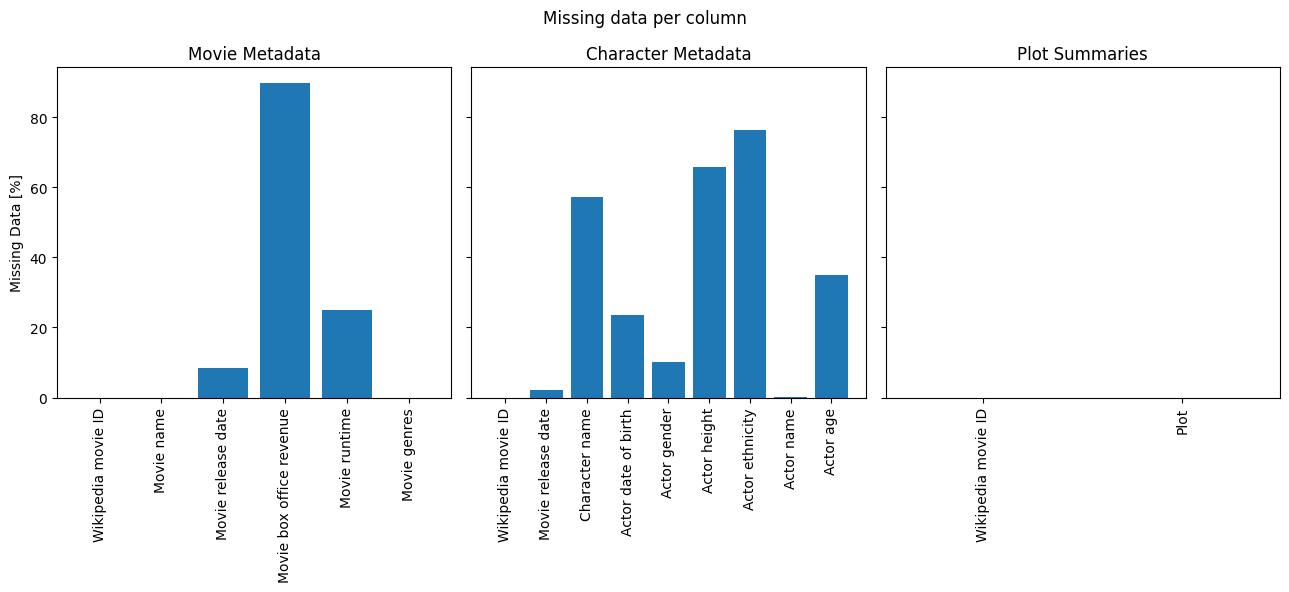

--- Dataset shapes ---
Movies metadata: (81741, 6)
Character metadata: (81741, 6)
Plot summaries: (42303, 2)


In [8]:
# Calculating missing data
missing_movie = meta_movie.isnull().sum() * 100 / len(meta_movie)
missing_char = meta_charac.isnull().sum() * 100 / len(meta_charac)
missing_plot = plot.isnull().sum() * 100 / len(plot)

# Plotting
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(13, 6), sharey=True)
fig.suptitle('Missing data per column')

# Set axis labels and titles
ax1.set(ylabel= 'Missing Data [%]')
ax1.bar(missing_movie.index, missing_movie.values)
ax1.tick_params(axis='x', labelrotation = 90)
ax1.set_title("Movie Metadata")
ax2.bar(missing_char.index, missing_char.values)
ax2.tick_params(axis='x', labelrotation = 90)
ax2.set_title("Character Metadata")
ax3.bar(missing_plot.index, missing_plot.values)
ax3.tick_params(axis='x', labelrotation = 90)
ax3.set_title("Plot Summaries")
plt.tight_layout()
plt.show()

print("--- Dataset shapes ---")
print("Movies metadata: {}" .format(meta_movie.shape))
print("Character metadata: {}" .format(meta_movie.shape))
print("Plot summaries: {}" .format(plot.shape))

*Observation:* From this initial analysis, it's evident that there is a significant amount of missing data.

*Action:* To address this, we've decided to drop certain actor features, specifically `character name` ,  `actor height`, `actor ethnicity`, and `actor age`, recognizing the high incidence of missing values in these columns. We are keeping `Movie box office revenue` but acknowledge the presence of missing values, and we plan to incorporate it into our analysis only if we have the resources and time to enrich our database.


In [9]:
charac = meta_charac.drop(columns=['Character name','Actor ethnicity', 'Actor height', 'Actor age'])

# 1. Dataframe 1: movies
## 1.1 Adding IMDb scores
We will start by adding the IMDb scores to the movie dataset, we want every movie in our dataset to have a rating, so we will use an **inner merge** (default) on the **title** and **year**. 

But first will need to have a look at the IMDb dataset.

In [10]:
# Display a sample of 5 rows from the 'imdb_title' DataFrame.
print("     ----- Title data sample -----")
display(imdb_title.sample(5))

# Display a sample of 5 rows from the 'imdb_ratings' DataFrame.
print("     ----- Raiting data overview -----")
display(imdb_raitings.sample(5))

     ----- Title data sample -----


,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,genres
1375315,tt10734890,tvEpisode,Episode #1.6,Episode #1.6,0,2009,Drama
4796992,tt18308092,tvEpisode,Episode #1.8979,Episode #1.8979,0,\N,"Drama,Romance"
7279968,tt3201312,tvSpecial,Premios Shock,Premios Shock,0,2010,Music
3576759,tt14776884,tvEpisode,Episode #1.310,Episode #1.310,0,\N,"Drama,Romance"
1652937,tt11233826,tvEpisode,Paranormal,Paranormal,0,2018,Reality-TV


     ----- Raiting data overview -----


,tconst,averageRating,numVotes
914580,tt23319872,9.2,6
1100672,tt4495668,8.1,8
1303016,tt8221738,6.9,524
283364,tt0538460,7.6,66
637071,tt1350611,7.4,9


In [11]:
# keep only movies
imdb_movieTitle = imdb_title[imdb_title['titleType'] == 'movie'].copy() 
# remove Nan years
imdb_movieTitle = imdb_movieTitle[imdb_movieTitle['startYear'] != '\\N'].copy() 
# turn year to int
imdb_movieTitle['startYear'] = imdb_movieTitle['startYear'].astype(int) 
# rename actor ID for ease of use
imdb_names.rename(columns={'nconst':'IMDb_actor_ID'}, inplace=True) 

# Merging the IMDb and CMU datasets
movies = meta_movie\
            .merge(imdb_movieTitle[['originalTitle','startYear','tconst']], left_on= ['Movie name', 'Movie release date'], right_on= ['originalTitle','startYear'], how= 'inner')\
            .merge(imdb_raitings, how ='inner')
movies.rename(columns={"tconst":"IMDb_ID"}, inplace= True) #rename IMDb ID for ease of use

print("--- Movie dataset size ---")
print(movies.shape)

--- Movie dataset size ---
(35612, 11)


The merge will only consider movies whose titles are an exact match which might not always be the case due to different capitalization of different coma placement. Thus the 35'000 rows that we get is a lower bound of the amount of rows that we could get if we used a more clever matching technique. For instance we could mitigate the problem of capitals matching by putting all strings to lower case.

## 1.2 Filtering
We are proceeding to filter outliers in the dataset. The goal is to identify and exclude any data points that deviate significantly from the general pattern, ensuring that our analysis is not influenced by extreme values.

In [12]:
# Save an unfieltered version of movies
movies_uf = movies.copy()

# We are removing outliers in the film duration to standardize our data
max_movie_runtime = 200 # [minutes]
min_movie_runtime = 40  # [minutes]
movies = movies.query('`Movie runtime` <= @max_movie_runtime and `Movie runtime` >= @min_movie_runtime').copy()

# To ensure enough films are available per year, we are removing the older and newer years
max_movie_year = 2012
min_movie_year = 1930
movies = movies.query('`Movie release date` <= @max_movie_year and `Movie release date` >= @min_movie_year').copy()


In [13]:
# Display a random sample of 5 rows from the 'movies' DataFrame.
movies.sample(5)

,Wikipedia movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie genres,originalTitle,startYear,IMDb_ID,averageRating,numVotes
10190,23881223,Call of the Yukon,1938,NaN,57.0,"{'/m/01jfsb': 'Thriller', '/m/03npn': 'Horror'...",Call of the Yukon,1938,tt0029961,5.3,150
23658,2711882,Bhaji on the Beach,1993,NaN,100.0,"{'/m/01t_vv': 'Comedy-drama', '/m/0219x_': 'In...",Bhaji on the Beach,1993,tt0106408,6.4,1217
23861,571383,Exorcist II: The Heretic,1977,30749142.0,112.0,"{'/m/01q03': 'Cult', '/m/03npn': 'Horror', '/m...",Exorcist II: The Heretic,1977,tt0076009,3.8,27599
339,19036329,The Happy Road,1957,NaN,99.0,{'/m/01z4y': 'Comedy'},The Happy Road,1957,tt0050483,5.9,462
32550,25562315,Here,2009,NaN,86.0,"{'/m/0vgkd': 'Black comedy', '/m/07s9rl0': 'Dr...",Here,2009,tt1426364,5.7,64


# 2. Dataframe 2 : Actors
## 2.1 Extracting main characters from IMDb 


In [14]:
# Input: 
#   - movies: DataFrame containing movie dataset 
#   - imdb_principals: IMDb dataset with principal actors
#   - top_n: Number of principal actors to extract (default 3) [int]
# Output: 
#   - movie_actors: DataFrame with all actors per film. Columns: IMDb_ID, actor, ordering (corresponds to the significance of actors in films)
def get_top_actors(movies, imdb_principals, top_n=3):
    # Filter the 'imdb_principals' DataFrame to include only rows where the category is 'actor' or 'actress'.
    imdb_principal_actors = imdb_principals.query('category == "actor" | category == "actress"')

    # Further filter the above DataFrame to include only those actors/actresses that appear in the 'movies' DataFrame (matched by 'IMDb_ID')
    # and are within the top 'top_n' ordering. 'ordering' likely refers to the importance or lead level of the actor in the movie.
    imdb_principal_actors_valid = imdb_principal_actors[(imdb_principal_actors["IMDb_ID"].isin(movies["IMDb_ID"].values.tolist())) & 
                                                        (imdb_principal_actors["ordering"] <= top_n)]

    # Initialize an empty list to store movie-actor pairings.
    movie_actors = []

    bar = progressbar.ProgressBar(maxval=len(movies["IMDb_ID"])).start()

    # Iterate over each movie ID in the 'movies' DataFrame.
    for idx, id in enumerate(movies["IMDb_ID"]):
         # For each movie, find corresponding actors from 'imdb_principal_actors_valid' and select 'ordering' and 'IMDb_actor_ID'.
        tmp = imdb_principal_actors_valid.loc[imdb_principal_actors_valid["IMDb_ID"] == id][["ordering", "IMDb_actor_ID"]]

        # Append each actor's information along with the movie ID to the 'movie_actors' list.
        for _, row in tmp.iterrows():
            movie_actors.append([id, row["IMDb_actor_ID"], row["ordering"]])
        bar.update(idx)

    # Convert the 'movie_actors' list into a DataFrame for easier handling and readability.
    movie_actors = pd.DataFrame(movie_actors, columns=['IMDb_ID', 'IMDb_actor_ID', 'ordering'])

    # Return the resulting DataFrame.
    return movie_actors

In [15]:
# takes ~5 mins to run
imdb_principals.rename(columns={'nconst':'IMDb_actor_ID'}, inplace=True)
imdb_principals.rename(columns={'tconst':'IMDb_ID'}, inplace=True)

movie_actors = get_top_actors(movies, imdb_principals)
movie_actors.sample(5)

,IMDb_ID,IMDb_actor_ID,ordering
40163,tt0118632,nm0000380,1
48219,tt1683003,nm0001626,1
67344,tt0119214,nm0000582,1
10292,tt0076782,nm0851182,1
69979,tt0476958,nm1140300,3


## 2.2 Creating a one-to-many relationship
We want a one-to-many relationship between movies and movie_actors, i.e for every movie_actor, there is **exactly** one corresponding movie (no NaNs).

In [28]:
# creation of the DataFrame only with valid actors
movies = movies[movies["IMDb_ID"].isin(movie_actors["IMDb_ID"].unique().tolist())]

## 2.3 Adding information to the dataset
We will now added additional data to the actors dataset

In [89]:
# takes ~10 seconds
# Merge 'movie_actors' with selected columns from 'movies' and 'imdb_names' DataFrames.
actors = movie_actors.merge(movies[['Wikipedia movie ID', 'Movie name', 'Movie release date', 'IMDb_ID']], on='IMDb_ID')
actors = actors.merge(imdb_names[['primaryName', 'IMDb_actor_ID', 'birthYear']], left_on='IMDb_actor_ID', right_on='IMDb_actor_ID')

# Display a sample of 5 rows from the resulting 'actors' DataFrame.
actors.sample(5)

,IMDb_ID,IMDb_actor_ID,ordering,Wikipedia movie ID,Movie name,Movie release date,primaryName,birthYear
42873,tt4772986,nm3054665,2,20288060,Mastan,2004,Swastika Mukherjee,1980
2127,tt0082332,nm0001265,2,5137533,Enter the Ninja,1981,Susan George,1950
3027,tt0305689,nm0620785,1,5090136,Jab Jab Phool Khile,1965,Nanda Karnataki,1939
31771,tt1860215,nm0695177,3,30523766,Dongala Mutha,2011,Prakash Raj,1965
44729,tt0285861,nm0000450,1,1244822,Owning Mahowny,2003,Philip Seymour Hoffman,1967


In [90]:
actors

,IMDb_ID,IMDb_actor_ID,ordering,Wikipedia movie ID,Movie name,Movie release date,primaryName,birthYear
0,tt0228333,nm0000449,1,975900,Ghosts of Mars,2001,Natasha Henstridge,1974
1,tt0115471,nm0000449,2,9340076,Adrenalin: Fear the Rush,1996,Natasha Henstridge,1974
2,tt0114508,nm0000449,1,689763,Species,1995,Natasha Henstridge,1974
3,tt0327247,nm0000449,3,1026994,The Whole Ten Yards,2004,Natasha Henstridge,1974
4,tt0120841,nm0000449,1,704406,Species II,1998,Natasha Henstridge,1974
...,...,...,...,...,...,...,...,...
82502,tt1606259,nm4774361,2,34980460,Knuckle,2011,Paddy Quinn McDonagh,\N
82503,tt1606259,nm4774484,3,34980460,Knuckle,2011,Michael Quinn McDonagh,\N
82504,tt0362411,nm0514648,1,9971909,Another Nice Mess,1972,Rich Little,1938
82505,tt0362411,nm0901343,2,9971909,Another Nice Mess,1972,Herb Voland,1918


## 2.4 Adding Actors' connections

In [91]:
# Create an empty dictionary to store centrality values for each year
centrality_dict = {}

# Loop over unique years
for year in actors['Movie release date'].unique():
    # Filter the DataFrame up to the current year
    current_year_data = actors[actors['Movie release date'] <= year]

    # Create an empty graph for the current year
    B = nx.Graph()

    # Iterate through each row in the data for the current year
    for index, row in current_year_data.iterrows():
        actor_id = row['IMDb_actor_ID']
        movie_id = row['IMDb_ID']

        # Add nodes with the 'bipartite' attribute
        B.add_node(actor_id, bipartite=0)
        B.add_node(movie_id, bipartite=1)

        # Add an edge between the actor and the movie
        B.add_edge(actor_id, movie_id)

    # Project the bipartite graph onto the actor nodes
    actor_nodes = [n for n, d in B.nodes(data=True) if d['bipartite'] == 0]
    actor_graph = nx.bipartite.projected_graph(B, nodes=actor_nodes)

    # Calculate the degree of centrality
    centrality = nx.degree_centrality(actor_graph)

    # Add centrality values to the dictionary for the current year
    centrality_dict[year] = centrality.copy()

In [92]:
# Convert the dictionary of centrality values to a DataFrame
centrality_df = pd.DataFrame.from_dict(centrality_dict, orient='columns').stack().to_frame().reset_index()
centrality_df = centrality_df.rename(columns={"level_0": "IMDb_actor_ID", "level_1": "Movie release date", 0:"actor_connections"})

# tmp=actors.reset_index()
actors = pd.merge(actors,centrality_df, on=["IMDb_actor_ID","Movie release date"], how = "inner")

## 2.4 Adding awards feature

As a specific actor feature, we want to use the number of awards won. To do this we use a kaggle dataset ([link](https://www.kaggle.com/datasets/unanimad/the-oscar-award/code)).


In [93]:
print("kaggle awards shape: " + str(kaggle_awards.shape))
kaggle_awards.sample(5)

kaggle awards shape: (1550, 6)


,year_film,year_ceremony,ceremony,name,film,winner
2512,1951,1952,24,Arthur Kennedy,Bright Victory,False
1270,1942,1943,15,James Cagney,Yankee Doodle Dandy,True
5316,1975,1976,48,Lily Tomlin,Nashville,False
5201,1974,1975,47,Ellen Burstyn,Alice Doesn't Live Here Anymore,True
5107,1973,1974,46,Sylvia Sidney,"Summer Wishes, Winter Dreams",False


We should filter to keep only movies that are in our dataset

In [94]:
# Keep only actors that are in our actors DataFrame
kaggle_awards = kaggle_awards[kaggle_awards['name'].isin(actors['primaryName'].unique())]
# Keep only movies that are in our movies DataFrame
kaggle_awards = kaggle_awards[kaggle_awards['film'].isin(movies['Movie name'].unique())]
kaggle_awards.sample(5)

,year_film,year_ceremony,ceremony,name,film,winner
6152,1983,1984,56,Albert Finney,The Dresser,False
7118,1992,1993,65,Emma Thompson,Howards End,True
8351,2003,2004,76,Keisha Castle-Hughes,Whale Rider,False
4560,1968,1969,41,Alan Arkin,The Heart Is a Lonely Hunter,False
4214,1965,1966,38,Samantha Eggar,The Collector,False


Let's have a quick scan of the amount of NaNs in this new dataset

In [95]:
kaggle_nans = kaggle_awards.isnull().sum() * 100 / len(kaggle_awards)
display(kaggle_nans)

year_film        0.0
year_ceremony    0.0
ceremony         0.0
name             0.0
film             0.0
winner           0.0
dtype: float64

As we can see, the dataset is NaNs free.

Let's now define a function to get the number of awards won by a given actor up until a given year. For this feature we will only consider the number of awards that the actor won before the movie was released. Using this function we will be able to add a new column in our previous dataframe. 

The function allow counting both the amount of awards won but also the number of nominations

In [96]:
# Input: 
#   - actor_name (str)
#   - year (int)
#   - won (bool) -> Was the nomination won 
# Output:
#   - Number of awards/nominations gained by the actor
def count_awards(actor_name, year, won):
    # We check with the ceremony year because the actor hasn't recieved an award until the ceremony has happened
    if won:
        filtered = kaggle_awards.query("year_ceremony <= @year & name == @actor_name & winner==True")
    else:
        filtered = kaggle_awards.query("year_ceremony <= @year & name == @actor_name")
    
    return len(filtered)

In [97]:
# Takes ~5 mins
# Add 'awards' and 'nominations' columns to the 'actors' DataFrame, calculated using the 'count_awards' function.
actors['awards'] = [count_awards(row['primaryName'], row['Movie release date'], True) for (index, row) in actors.iterrows()]
actors['nominations'] = [count_awards(row['primaryName'], row['Movie release date'], False) for (index, row) in actors.iterrows()]

Let's take a look at Meryl Streep's films as an example to showcase what this function has done

In [98]:
actors.query("primaryName == 'Meryl Streep'").sort_values('Movie release date').head(10)

,IMDb_ID,IMDb_actor_ID,ordering,Wikipedia movie ID,Movie name,Movie release date,primaryName,birthYear,actor_connections,awards,nominations
6766,tt0079417,nm0000658,2,103026,Kramer vs. Kramer,1979,Meryl Streep,1949,0.000361,0,1
6767,tt0079875,nm0000658,3,9090163,The Seduction of Joe Tynan,1979,Meryl Streep,1949,0.000361,0,1
6768,tt0082416,nm0000658,1,3602324,The French Lieutenant's Woman,1981,Meryl Streep,1949,0.000512,1,2
6777,tt0084707,nm0000658,1,4016437,Sophie's Choice,1982,Meryl Streep,1949,0.000828,1,3
6776,tt0084732,nm0000658,2,11612605,Still of the Night,1982,Meryl Streep,1949,0.000828,1,3
6785,tt0086312,nm0000658,1,242548,Silkwood,1983,Meryl Streep,1949,0.000971,2,4
6792,tt0087233,nm0000658,2,6123971,Falling in Love,1984,Meryl Streep,1949,0.001100,2,5
6797,tt0089755,nm0000658,1,89793,Out of Africa,1985,Meryl Streep,1949,0.001370,2,5
6798,tt0089816,nm0000658,1,3066519,Plenty,1985,Meryl Streep,1949,0.001370,2,5
6787,tt0091188,nm0000658,1,2052231,Heartburn,1986,Meryl Streep,1949,0.001476,2,6


## 2.5 Adding the number of movies per actor (total and in said genre)

In [79]:
# Sort the DataFrame by actor ID and movie release date
actors_sorted = actors.sort_values(by=['IMDb_actor_ID', 'Movie release date'])

# Group by actor ID and calculate cumulative count of movies
actors_sorted['movie_count'] = actors_sorted.groupby('IMDb_actor_ID').cumcount() + 1

# If you need to maintain the original order of the actors DataFrame
actors['movie_count'] = actors_sorted['movie_count']


## 2.6 Number of different genres that the actor has played in (diversity)

In [80]:
# Joining the two datasets actors and movies
tmp = actors.join(movies, how='left', lsuffix='_actors', rsuffix='_movies')
# We turn the movie genres dict into a list
tmp["Movie genres"] = tmp["Movie genres"].apply(lambda x: [] if pd.isna(x) else list(x.values()))


In [101]:
# Input:
#   - actor_name (str)
#   - year (int)
# Output:
#   - Number of genres played by the actor until the given year
def count_nb_genres_b4(actor_name, year):
    all_genres_b4 = tmp[(tmp["Movie release date_actors"] <= year) & (tmp["IMDb_actor_ID"] == actor_name)]["Movie genres"].explode().unique()
    return len(all_genres_b4)

actors['genre_diversity'] = [count_nb_genres_b4(row['IMDb_actor_ID'], row['Movie release date_actors']) for (index, row) in tmp.iterrows()]

## 2.8 Adding actor's sex & age at time of movie

In [133]:
# Merging the IMDb and CMU datasets for the character sex
actors = actors.merge(charac[["Actor name",  "Actor gender"]].drop_duplicates(subset=['Actor name']), how='left', left_on='primaryName', right_on='Actor name')
actors["is_male"] = actors["Actor gender"].apply(lambda x : 1 if x == "M" else (0 if x == "F" else np.nan)).astype(pd.Int64Dtype())
actors.drop(columns=["Actor name", "Actor gender"], inplace=True)

In [134]:
# Input:
#   - birth_year (int)
#   - release_year (int)
# Output:
#   - Age of the actor at the release of the movie
def age_at_release(birth_year, release_year):
    if pd.isna(birth_year) or pd.isna(release_year) or birth_year == "\\N" or release_year == "\\N":
        return np.nan
    else:
        return int(release_year) - int(birth_year)

actors["age_at_release"] = [age_at_release(row['birthYear'], row['Movie release date']) for (index, row) in actors.iterrows()]
actors["age_at_release"] = actors["age_at_release"].astype(pd.Int64Dtype())
actors.drop(columns=["birthYear"], inplace=True)

KeyError: 'birthYear'

## 2.9 Replacing \\\N values with NaN

In [135]:
actors = actors.replace("\\N", pd.NA)
movies = movies.replace("\\N", pd.NA)

In [136]:
actors.sample(5)

,ordering,Wikipedia movie ID,Movie name,Movie release date,primaryName,actor_connections,awards,nominations,genre_diversity,isMale,age_at_release,is_male
40034,3,21745410,Latin Lovers,1953,John Lund,0.006140,0,0,1,1,42,1
67812,2,22645001,All Stars,1997,Antonie Kamerling,0.000110,0,0,1,1,31,1
2850,2,1940449,RoboCop 3,1993,Nancy Allen,0.001650,0,0,31,0,43,0
78534,3,5551144,Gridiron Gang,2006,L. Scott Caldwell,0.000081,0,0,1,0,56,0
18847,3,17395300,Dust Be My Destiny,1939,Alan Hale,0.003409,0,0,12,<NA>,47,<NA>


# 3 Final Data Analysis 
Let's take a look at what our final DataFrames look like
## 3.1 Dataframe 1: Movies

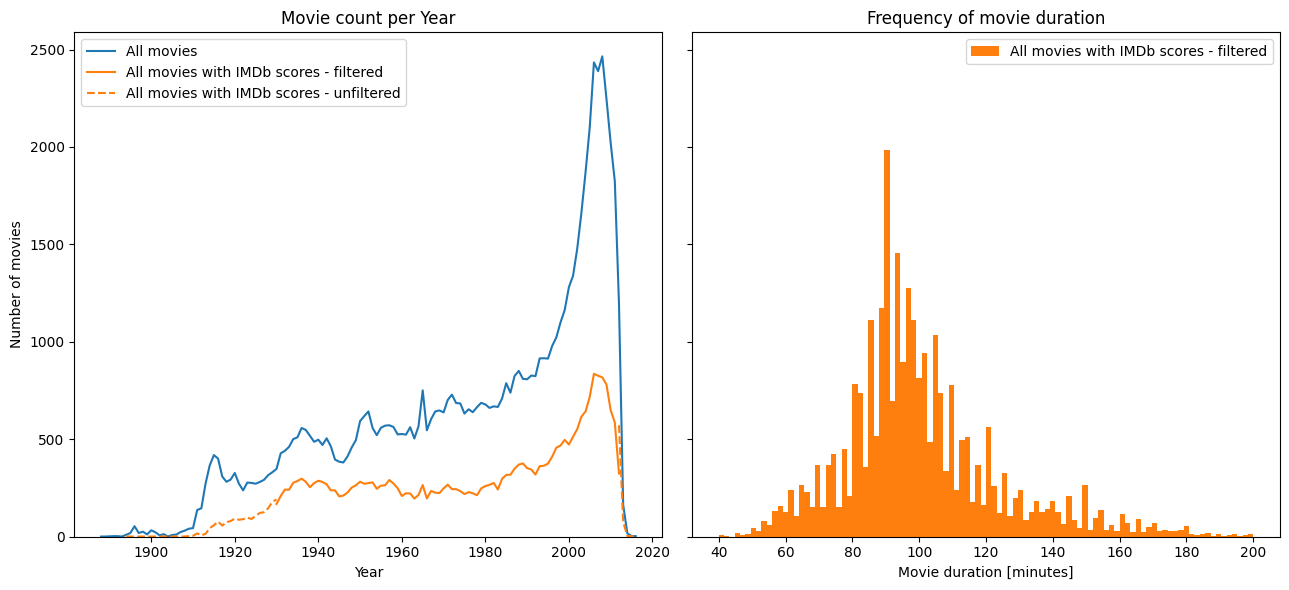

In [137]:
# Get unfiltered movies with IMDb scores -> Selecting years that will not be plotted with the filtered data
movies_ufR = movies_uf.query('`Movie release date` >= @max_movie_year').copy()
movies_ufL = movies_uf.query('`Movie release date` <= @min_movie_year').copy()

# There is a movie with a typo in the original dataset, we can manually correct this 
meta_movie["Movie release date"][meta_movie["Movie release date"]==1010] = 2010

# Count all movies without merging with IMDb
all_movie_counts = meta_movie['Wikipedia movie ID'].groupby(meta_movie['Movie release date']).count()

# Count movies after merging with IMDb with and without filtering
movie_counts = movies['Wikipedia movie ID'].groupby(movies['Movie release date']).count()
movie_counts_ufL = movies_ufL['Wikipedia movie ID'].groupby(movies_ufL['Movie release date']).count()
movie_counts_ufR = movies_ufR['Wikipedia movie ID'].groupby(movies_ufR['Movie release date']).count()

#       ----- PLOT -----
fig, axes = plt.subplots(1, 2, figsize=(13, 6), sharey= True)

# subplot 1: plot the counts of all movies
axes[0].set_title('Movie count per Year')
axes[0].set_ylabel('Number of movies')
axes[0].set_xlabel('Year')
axes[0].plot(all_movie_counts.index, all_movie_counts.values, color= 'C0', label= 'All movies')
axes[0].plot(movie_counts.index, movie_counts.values, color= 'C1', label= 'All movies with IMDb scores - filtered')
axes[0].plot(movie_counts_ufL.index, movie_counts_ufL.values, color= 'C1', linestyle = '--',label= 'All movies with IMDb scores - unfiltered')
axes[0].plot(movie_counts_ufR.index, movie_counts_ufR.values, color= 'C1', linestyle = '--')
axes[0].legend(loc="upper left")

axes[1].set_title('Frequency of movie duration')
axes[1].set_xlabel('Movie duration [minutes]')
axes[1].hist(movies['Movie runtime'], bins = 100, color = 'C1', label= 'All movies with IMDb scores - filtered')
axes[1].legend(loc="upper right")

plt.tight_layout()
plt.show()

*Observation:* We have significantly reduced the number of films in our dataset. However, the distribution of drama movies is similar to the all movies with IMDb scores in both `Release date` and `Film duration`. We still have close to 15'000 drama movies to base our analysis on.

In [138]:
# Display descriptive statistics for selected columns in the 'movies' DataFrame:
# - 'Movie release date'
# - 'Movie box office revenue'
# - 'Movie runtime'
# - 'startYear'
# - 'averageRating'
# - 'numVotes'
movies[['Movie release date','Movie box office revenue','Movie runtime','startYear','averageRating','numVotes']].describe()

,Movie release date,Movie box office revenue,Movie runtime,startYear,averageRating,numVotes
count,27635.0,6.607000e+03,27635.000000,27635.000000,27635.000000,2.763500e+04
mean,1979.007237,5.337970e+07,100.186393,1979.007237,6.107288,2.128807e+04
std,25.181717,1.174647e+08,23.517354,25.181717,1.063079,9.199031e+04
min,1930.0,1.140800e+04,40.000000,1930.000000,1.100000,5.000000e+00
25%,1957.0,2.500000e+06,87.000000,1957.000000,5.500000,2.480000e+02
50%,1985.0,1.320429e+07,96.000000,1985.000000,6.200000,1.103000e+03
75%,2002.0,4.923197e+07,110.000000,2002.000000,6.800000,5.953000e+03
max,2012.0,2.782275e+09,200.000000,2012.000000,9.700000,2.816055e+06


Now lets work on the **movie genres**, we can use the fact that they are a dictionary to have a look at their frequency

## 3.2 Dataframe 2: Actors

In [141]:
actors

,ordering,Wikipedia movie ID,Movie name,Movie release date,primaryName,actor_connections,awards,nominations,genre_diversity,isMale,age_at_release,is_male
0,1,975900,Ghosts of Mars,2001,Natasha Henstridge,0.000833,0,0,22,0,27,0
1,2,2195094,Kevin of the North,2001,Natasha Henstridge,0.000833,0,0,22,0,27,0
2,2,9340076,Adrenalin: Fear the Rush,1996,Natasha Henstridge,0.000341,0,0,9,0,22,0
3,2,4163034,Maximum Risk,1996,Natasha Henstridge,0.000341,0,0,9,0,22,0
4,1,689763,Species,1995,Natasha Henstridge,0.000117,0,0,6,0,21,0
...,...,...,...,...,...,...,...,...,...,...,...,...
82502,2,34980460,Knuckle,2011,Paddy Quinn McDonagh,0.000068,0,0,1,<NA>,<NA>,<NA>
82503,3,34980460,Knuckle,2011,Michael Quinn McDonagh,0.000068,0,0,1,<NA>,<NA>,<NA>
82504,1,9971909,Another Nice Mess,1972,Rich Little,0.000218,0,0,1,1,34,1
82505,2,9971909,Another Nice Mess,1972,Herb Voland,0.000218,0,0,1,1,54,1


In [140]:
# Count the number of unique IMDb actor IDs in the 'actors' DataFrame.
unique_actors = len(actors['IMDb_actor_ID'].unique())

print('There are {} unique actors out of {} entries. A actor plays on average in {} films' .format(unique_actors, len(actors.index),len(actors.index)/unique_actors))

KeyError: 'IMDb_actor_ID'

This shows that there is a good range of actors in our dataset (i.e we don't have a large amount of different actors).

In [114]:
# Display a random sample of 5 rows from the 'actors' DataFrame.
actors.sample(5)

,IMDb_ID,IMDb_actor_ID,ordering,Wikipedia movie ID,Movie name,Movie release date,primaryName,birthYear,actor_connections,awards,nominations,genre_diversity,isMale,age_at_release
66345,tt0096968,nm0706921,1,24092798,Boris Godounov,1989,Ruggero Raimondi,1941,0.000402,0,0,1,1,48
15744,tt0795438,nm0004820,1,20629940,Not Easily Broken,2009,Morris Chestnut,1969,0.000678,0,0,23,1,40
66095,tt0047025,nm0208375,1,28224307,Un giorno in pretura,1954,Peppino De Filippo,1903,0.000813,0,0,1,1,51
29694,tt0305973,nm0000950,2,20072102,Sonny,2002,Brenda Blethyn,1946,0.000758,0,2,21,0,56
79564,tt0099401,nm0487444,2,28715960,Demon Wind,1990,Francine Lapensée,<NA>,0.000131,0,0,1,<NA>,<NA>


In [115]:
# Display descriptive statistics for selected columns in the 'actors' DataFrame:
# - 'Movie release date'
# - 'awards'
# - 'nominations'
actors[['Movie release date','awards','nominations']].describe()

,Movie release date,awards,nominations
count,82507.0,82507.000000,82507.000000
mean,1978.963833,0.048044,0.216188
std,25.197078,0.245127,0.811500
min,1930.0,0.000000,0.000000
25%,1957.0,0.000000,0.000000
50%,1985.0,0.000000,0.000000
75%,2002.0,0.000000,0.000000
max,2012.0,4.000000,17.000000


*Observation:* We can see that, on average, an actor has less than 0.05 Oscars, which may be an important factor if there is a correlation with the frequency of an actor's selection

# 4 Final dataframe setup and export

In [116]:
actors.set_index(['IMDb_ID','IMDb_actor_ID'], inplace=True)


In [123]:
no_features = 8
no_info = len(actors.columns)- no_features

# prepare MultiIndexing
col_cat= ["Info"]*no_info + ["Features"] * no_features
cols = list(zip(col_cat,actors.columns))

# create MultiIndexing
actors.columns=pd.MultiIndex.from_tuples(cols)


In [125]:
# Pickle data to use later
actors.to_pickle("./data/actors.pkl")
movies.to_pickle("./data/movies.pkl")

In [132]:
actors

ordering  Wikipedia movie ID  \
IMDb_ID   IMDb_actor_ID                                 
tt0228333 nm0000449             1              975900   
tt0251174 nm0000449             2             2195094   
tt0115471 nm0000449             2             9340076   
tt0117011 nm0000449             2             4163034   
tt0114508 nm0000449             1              689763   
...                           ...                 ...   
tt1606259 nm4774361             2            34980460   
          nm4774484             3            34980460   
tt0362411 nm0514648             1             9971909   
          nm0901343             2             9971909   
          nm0930443             3             9971909   

                                       Movie name  Movie release date  \
IMDb_ID   IMDb_actor_ID                                                 
tt0228333 nm0000449                Ghosts of Mars                2001   
tt0251174 nm0000449            Kevin of the North                2001   
tt0115471 nm0000449      Adrenalin: Fear the Rush                1996   
tt0117011 nm0000449                  Maximum Risk                1996   
tt0114508 nm0000449                       Species                1995   
...                                           ...                 ...   
tt1606259 nm4774361                       Knuckle                2011   
          nm4774484                       Knuckle                2011   
tt0362411 nm0514648             Another Nice Mess                1972   
          nm0901343             Another Nice Mess                1972   
          nm0930443             Another Nice Mess                1972   

                                    primaryName  actor_connections  awards  \
IMDb_ID   IMDb_actor_ID                                                      
tt0228333 nm0000449          Natasha Henstridge           0.000833       0   
tt0251174 nm0000449          Natasha Henstridge           0.000833       0   
tt0115471 nm0000449          Natasha Henstridge           0.000341       0   
tt0117011 nm0000449          Natasha Henstridge           0.000341       0   
tt0114508 nm0000449          Natasha Henstridge           0.000117       0   
...                                         ...                ...     ...   
tt1606259 nm4774361        Paddy Quinn McDonagh           0.000068       0   
          nm4774484      Michael Quinn McDonagh           0.000068       0   
tt0362411 nm0514648                 Rich Little           0.000218       0   
          nm0901343                 Herb Voland           0.000218       0   
          nm0930443              Diahn Williams           0.000218       0   

                         nominations  genre_diversity  isMale  age_at_release  
IMDb_ID   IMDb_actor_ID                                                        
tt0228333 nm0000449                0               22       0              27  
tt0251174 nm0000449                0               22       0              27  
tt0115471 nm0000449                0                9       0              22  
tt0117011 nm0000449                0                9       0              22  
tt0114508 nm0000449                0                6       0              21  
...                              ...              ...     ...             ...  
tt1606259 nm4774361                0                1    <NA>            <NA>  
          nm4774484                0                1    <NA>            <NA>  
tt0362411 nm0514648                0                1       1              34  
          nm0901343                0                1       1              54  
          nm0930443                0                1    <NA>              29  

[82507 rows x 11 columns]